# 15 - Synthetic Control

## One Amazing Math Trick to Learn What can’t be Known

When we looked at difference-in-difference, we had data on multiple customers from 2 different cities: Porto Alegre and Florianopolis. The data span 2 different time periods: before and after a marketing intervention was done in Porto Alegre to boost customer deposits. To estimate the treatment effect, we ran a regression that gave us the difference-in-difference estimator and its standard error. 

For that case, we had a lot of samples, because data was disaggregated. But what if all we have is aggregated data on the city level? For instance, let's pretend all we have is the average level of deposits in both cities before and after the intervention.

|city|before|after|
|--|--|--|
|FL|171.64|206.16|
|POA|46.01|87.06|

We would still be able to compute the Diff-in-Diff estimator 

$
(E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0]) = (87.06 - 206.16) - (46.01 - 171.64) = 6.53
$

However, note that the sample size here is 4, which is also the number of parameters in our Diff-in-Diff models. In this case, the standard error is not well defined, so what should we do? Another problem is that Florianopolis might not be as similar to Porto Alegre as we would want to. For instance, Florianopolis is known for its beautiful beaches and easy going people while Porto Alegre is more famous for its barbecue and prairies. The problem here is that you can't ever know for sure if you are using an appropriate control group. 

To work around this, we will use what is known as [**"the most important innovation in the policy evaluation literature in the last few years"**](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.3), Synthetic Controls. It is based on a simple, yet powerful idea. We don't need to find any single unit in the untreated that is very similar to the treated. Instead, we can forge our own as a combination of multiple untreated units, creating what is effectively a synthetic control. Synthetic control is so effective yet so intuitive that it even got an article published, not on a scientific journal, but on the [Washington Post](https://www.washingtonpost.com/news/wonk/wp/2015/10/30/how-to-measure-things-in-a-world-of-competing-claims/).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

To see it in action, consider the problem of estimating the effect of cigarette taxation on its consumption. To give a bit of context, this is a question that had been debated for a long time in economics. One side of the argument says that taxes will increase the cost of cigars, which will lower its demand. The other side argues that since cigarettes cause addiction, change in their price won't change their demand by much. In economic terms, we would say that the demand for cigarettes is inelastic on price, and an increase in taxation is just a way to increase government income at the cost of smokers. To settle things, we will look at some US data regarding the matter.

In 1988, California passed a famous Tobacco Tax and Health Protection Act, which became known as [Proposition 99](https://en.wikipedia.org/wiki/1988_California_Proposition_99). "Its primary effect is to impose a 25-cent per pack state excise tax on the sale of tobacco cigarettes within California, with approximately equivalent excise taxes similarly imposed on the retail sale of other commercial tobacco products, such as cigars and chewing tobacco. Additional restrictions placed on the sale of tobacco include a ban on cigarette vending machines in public areas accessible by juveniles, and a ban on the individual sale of single cigarettes. Revenue generated by the act was earmarked for various environmental and health care programs, and anti-tobacco advertisements." 

To evaluate its effect, we can gather data on cigarette sales from multiple states and across a number of years. In our case, we got data from the year 1970 to 2000 from 39 states. Other states had similar Tobacco control programs and were dropped from the analysis. Here is what our data looks like.

In [3]:
cigar = (pd.read_csv("data/smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california").head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


We have `state` as the state index, where California is the number 3. Our covariates are `retprice`, the cigarette retail price, and `cigsale`, the per-capita sales of cigarettes in packs. Our outcome variable of interest is `cigsale`. Finally, we have boolean helper variables to signal the state of California and the post intervention period. If we plot the sales of cigarettes for California and other states across time, this is what we would get.

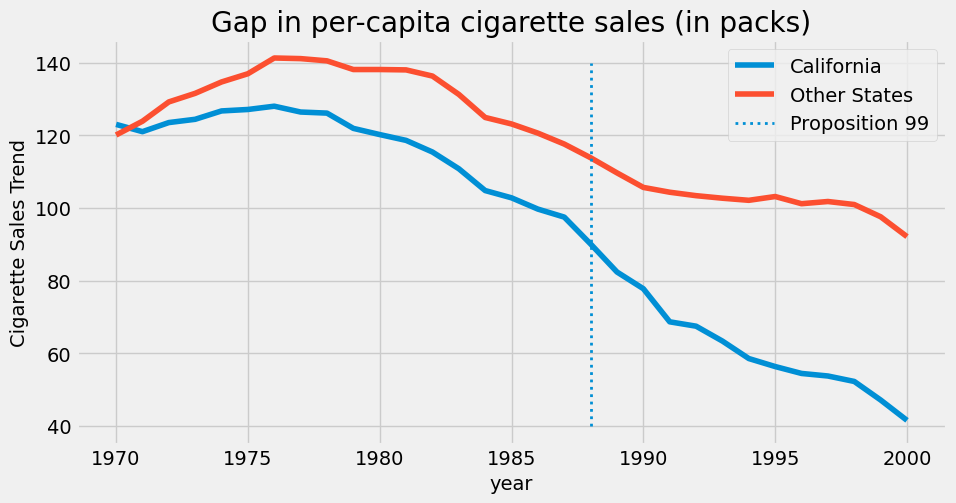

In [4]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot("year", "california", "cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();  

During the time for which we have data, people in California apparently bought less cigarettes than the national average. Also, it appears to be a decreasing movement in cigarette consumption after the 80s. It looks like after Proposition 99 the decreasing trend accelerated for California, compared to other states, but we can't say that for sure. It is just a guess that we have by examining the plot. 

To answer the question of whether Proposition 99 had an effect on cigarette consumption, we will use the pre-intervention period to build a synthetic control. We will combine the other states to **build a fake state that resembles very closely the trend of California**. Then, we will see how this synthetic control behaves after the intervention. 

## We have Time

To make matters a little bit more formal, suppose that we have $J+1$ units. Without loss of generality, assume that unit 1 is the unit that gets affected by an intervention. Units $j=2,...,J+1$ are a collection of untreated units that we will refer to as the "donor pool". Also assume that the data we have span T time periods, with $T_0$ periods before the intervention. For each unit j and each time t, we observe the outcome $Y_{jt}$. For each unit j and period t, define $Y^N_{jt}$ as the potential outcome without intervention and $Y^I_{jt}$, the potential outcome with intervention. Then, the effect for the treated unit $j=1$ at time t, for $t>T_0$ is defined as 

$
\tau_{1t} = Y^I_{1t} - Y^N_{1t}
$

Since unit $j=1$ is the treated one, $Y^I_{1t}$ is factual but $Y^N_{1t}$ is not. The challenge then becomes how do we estimate $Y^N_{1t}$. Notice how the treatment effect is defined for each period, which means it can change in time. It doesn't need to be instantaneous. It can accumulate or dissipate. To put it in a picture, the problem of estimating the treatment effect boils down to the problem of **estimating what would have happened to the outcome of unit $j=1$ if it had not been treated**.

![img](data/img/synth-control/synth_img.png)

To estimate $Y^N_{1t}$, we remember that a combination of units in the donor pool may approximate the characteristics of the treated unit much better than any untreated unit alone. Thus, a synthetic control is defined as a weighted average of the units in the control pool. Given the weights $\pmb{W}=(w_2, ..., w_{J+1})$, the synthetic control estimate of $Y^N_{1t}$ is

$
\hat{Y}^N_{1t} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

If all this math makes your head hurt, you are not alone. But don't worry, we have lots of examples to make it more intuitive. For once, I like to think about synthetic control as an upside down way of doing regression. As we know, linear regression is also a way of getting the prediction as a weighted average of the variables. Now, think about those regressions like the one in the diff-in-diff example where each variable is a dummy for a time period. In this case, regression can be represented as the following matrix multiplication

![img](data/img/synth-control/regr_time.png)

On the synthetic control case, we don't have lots of units, but we do have lots of time periods. So what we do is flip the input matrix around. Then, the units become the "variables" and we represent the outcome as a weighted average of the units, like in the following matrix multiplication.

![img](data/img/synth-control/regr_space.png)

If we have more than one feature per time period, we can pile up the features like this. The important thing is to make it so that the regression is trying to "predict" the treated unit 1 by using the other units. This way, we can choose the weights in some optimal way to achieve this proximity we want. We can even scale features differently to give different importance to them.

![img](./data/img/synth-control/regr_space_x.png)

So, if synthetic control can be viewed as a linear regression, it also means that we can estimate its weights with OLS right? Yup! In fact, let's do this now.


## Synthetic Control as Linear Regression

![img](./data/img/synth-control/allways.png)

To estimate the treatment effect with synthetic control, we will try to build a "fake unit" that resembles the treated unit before the intervention period. Then, we will see how this "fake unit" behaves after the intervention. The difference between the synthetic control and the unit that it mimics is the treatment effect.

To do this with linear regression, we will find the weight using OLS. We will minimise the square distance between the weighted average of the units in the donor pool and the treated unit for the pre-intervention period.

To do so, the first thing we need is to convert the units (in our case, the states) into the columns and the time into the rows. Since we have 2 features, `cigsale` and `retprice`, we will pile them on top of each other like we did in the picture above. We will build a synthetic control that looks a lot like California in the pre intervention period and see how it would behave in the post intervention period. For this reason, it is important that we select only the pre-intervention period. Here, the features seem to be on a similar scale, so we won't do anything to them. If features are in different scales, one in the thousands and another in the decimals, the bigger feature will be the most important when minimizing the difference. To avoid this, it's important to scale them first.

> Insert by dataqubit

In [14]:
cigar

,state,year,cigsale,retprice,california,after_treatment
0,1,1970,89.800003,39.599998,False,False
1,1,1971,95.400002,42.700001,False,False
2,1,1972,101.099998,42.299999,False,False
3,1,1973,102.900002,42.099998,False,False
4,1,1974,108.199997,43.099998,False,False
...,...,...,...,...,...,...
1204,39,1996,110.300003,162.500000,False,True
1205,39,1997,108.800003,164.100006,False,True
1206,39,1998,102.900002,168.800003,False,True
1207,39,1999,104.800003,189.600006,False,True


In [9]:
features

['cigsale', 'retprice']

In [8]:
(cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features]).head()

cigsale                          ...    retprice              \
year         1970        1971        1972  ...        1986        1987   
state                                      ...                           
1       89.800003   95.400002  101.099998  ...  103.000000  110.000000   
2      100.300003  104.099998  103.900002  ...  103.599998  113.000000   
3      123.000000  121.000000  123.500000  ...  104.400002  103.900002   
4      124.800003  125.500000  134.300003  ...   95.099998  108.599998   
5      120.000000  117.599998  110.800003  ...  118.500000  122.699997   

                   
year         1988  
state              
1      114.400002  
2      119.900002  
3      117.400002  
4      116.000000  
5      129.699997  

[5 rows x 38 columns]

> End of Insert

In [7]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3   ...          37          38  \
        year                                      ...                           
cigsale 1970   89.800003  100.300003  123.000000  ...  114.500000  106.400002   
        1971   95.400002  104.099998  121.000000  ...  111.500000  105.400002   
        1972  101.099998  103.900002  123.500000  ...  117.500000  108.800003   
        1973  102.900002  108.000000  124.400002  ...  116.599998  109.500000   
        1974  108.199997  109.699997  126.699997  ...  119.900002  111.800003   

state                 39  
        year              
cigsale 1970  132.199997  
        1971  131.699997  
        1972  140.000000  
        1973  141.199997  
        1974  145.800003  

[5 rows x 39 columns]

Now, we can define our Y variable as the state of California and the X as the other states.

In [10]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

Then, we run a regression. Having an intercept is equivalent to adding another state where every row is 1. You can do that, but I think it's more complicated and I'll just leave it out. The regression will return the set of weights that minimize the square difference between the treated unit and the units in the donor pool.

In [11]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

These weights show us how to build the synthetic control. We will multiply the outcome of state 1 by -0.436, of state 2 by -1.038, of state 4 by 0.679 and so on. We can achieve this with a dot product between the matrix from the states in the pool and the weights.

In [12]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

Now that we have our synthetic control, we can plot it with the outcome variable of the State of California.

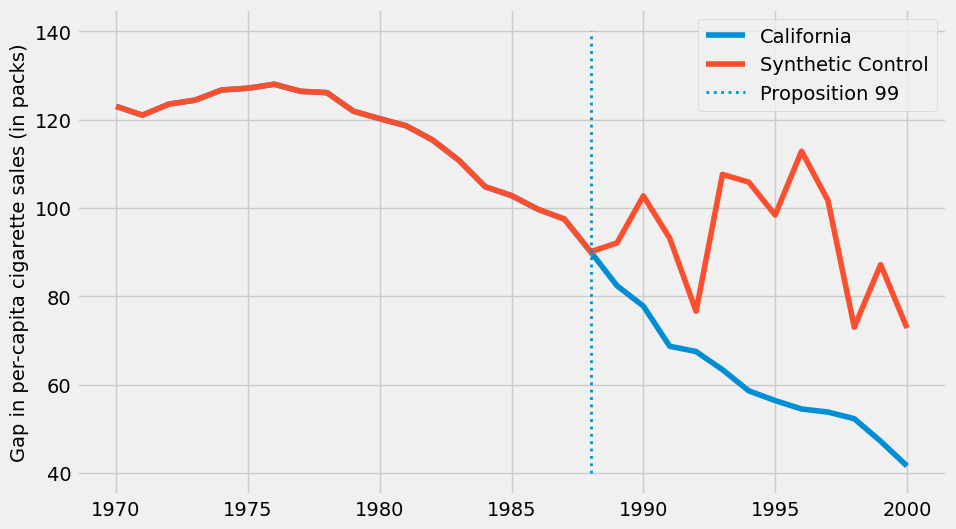

In [13]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

OK… Something seems off. What grabs your attention in this picture? First, after the intervention, the synthetic control has more cigarette sales than California. This is an indicative that the intervention was successful in lowering cigarette demand. Second, notice how the pre-intervention period is fitted perfectly. The synthetic control is able to match the state of California exactly. This is a sign that our synthetic control model is probably overfitting the data. Another sign is the huge variance on the outcome variable of the synthetic control after the intervention. Notice how it doesnt follow smooth patterns. Instead, it goes up and down and up and down. 

![img](./data/img/synth-control/out-of-sample.png)

If we think about why this is happening, remember that we have 38 states in our donor pool. So our linear regression has 38 parameters to play with in order to make the pretreatment pool match the treatment as close as it can. This is the case where, even if T is large, N is also large, which gives too much flexibility to our linear regression model. If you are familiar with regularized models, know that you could use Ridge or Lasso regression to fix this. Here, we will look at another more traditional way to avoid overfitting.

## Don't Extrapolate

Suppose you have data like in this table below and are asked to build a synthetic control to reproduce the treated unit using any linear combination of the control units.

|unit|sales|price|
|--|--|--|
|control 1|8|8|
|control 2|8|4|
|control 3|4|5|
|treated  |2|10|

Since there are 3 units and only 2 attributes to match, there are multiple exact solutions to this problem, but a nice one is multiplying the first control by 2.25, multiplying the second by -2 and adding both. Notice how the second multiplication creates a fake unit with sales of -16 and price of -8. This multiplication is extrapolating the control 2 unit to a region of the data that doesn't make a lot of sense, since negative price and sales are almost impossible. The first multiplication is also an extrapolation, since it takes the first unit to a region where sales and price are 18. These numbers are much higher than anything we have in our data, hence the extrapolation.

This is what regression is doing when we ask it to create a synthetic control. Extrapolation is not technically wrong, but it's dangerous in practice. We are making assumptions that the data we have never seen behaves like the data that we have. 

One way to play safer is to constrain our synthetic control to only do interpolation. To do so, we will restrict the weights to be positive and sum up to one. Now, the synthetic control will be a convex combination of the units in the donor pool. When doing interpolation, we will project the treated unit in the convex hull defined by the untreated unit, much like in the picture below.

![img](data/img/synth-control/extrapolation.png)

Notice two things here. First, interpolation won't be able to create a perfect match of the treated unit in this case. This is because the treated is the unit with the smallest number of sales and the highest price. Convex combinations can only replicate exactly features that are in between the control units. Another thing to notice is that interpolation is sparse. We will project the treated unit on a wall of the convex hull and this wall is defined only by a few units. For this reason, interpolation will assign weight zero to many of the units. 

This is the general idea, now let's formalize it a little bit. The synthetic control is still defined as 

$
\hat{Y}^N_{jt} = \sum^{J+1}_{j=2} w_j Y_{jt}
$

but now, we will use weights $\pmb{W}=(w_2, ..., w_{J+1})$ that minimises

$
||\pmb{X}_1 - \pmb{X}_0 \pmb{W}|| = \bigg(\sum^k_{h=1}v_h \bigg(X_{h1} - \sum^{J+1}_{j=2} w_j X_{hj} \bigg)^2 \bigg)^{\frac{1}{2}}
$

subject to the restriction that $w_2, ..., w_{J+1}$ are positive and sum to one. Notice that $v_h$ reflect the importance of each variable when minimising the difference between the treated and the synthetic control. Different $v$s would give different optimal weights. One way to choose $V$ is to make it so that each variable has mean zero and unit variance. A more complex way is to choose $V$ in such a way that variables that help to predict $Y$ better get higher importance. Since we want to keep the code simple, we will simply give the same importance for each variable.

To implement this, first, define the above loss function.

In [9]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

Since we are using the same importance for every feature, we don't need to worry about $v$.

Now, to get the optimal weights, we will use the quadratic programming optimisation of scipy. We will constrain the weights to sum up to 1 with 

```python 
lambda x: np.sum(x) - 1
```

Also, we will set optimization bounds to be between 0 and 1.

In [10]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

With this implemented, let's get the weights that define the synthetic control

In [11]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000424


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

With this weight, we are multiplying states 1,2, and 3 by zero, state 4 by 0.0852 and
so on. Notice how the weights are sparse, exactly as we've predicted. Also, all weights sum to one and are between 0 and 1, satisfying our convex combination constraint.

Now, to get the synthetic control, we can multiply those weights by the states exactly as we did before with the regression weights.

In [12]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

If we plot the outcome of the synthetic control now, we get a much smoother trend. Also notice that, in the pre intervention period, the synthetic control doesn't reproduce the treated exactly anymore. This is a good sign, as it indicates that we are not overfitting.

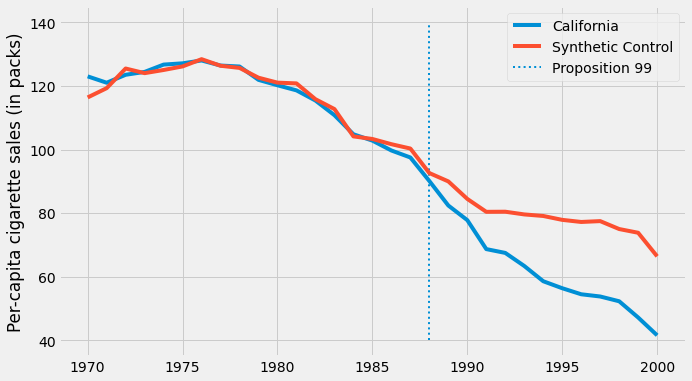

In [13]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

With the synthetic control at hand, we can estimate the treatment effect as the gap between treated and the synthetic control outcomes.

$
\tau_{1t} = Y^I_{jt} - Y^N_{jt}
$

In our particular case, the effect gets bigger and bigger as time passes.

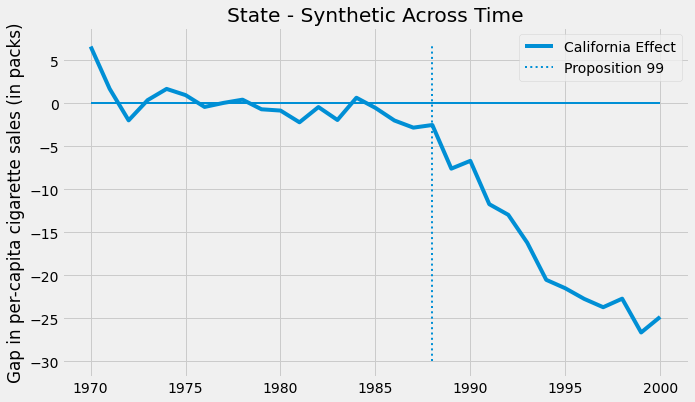

In [14]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

By the year 2000, it looks like Proposition 99 has reduced the sales in cigarettes by 25 packs. That is very cool and all, but something you might be asking yourself is: how can I know if this is statistically significant?

## Making Inference

Since our sample size is very small (39), we will have to be a bit smarter when figuring out if our result is statistically significant and not just due to random luck. Here, we will use the idea of Fisher's Exact Test. Its intuition is very simple. We permute the treated and control exhaustively. Since we only have one treated unit, this would mean that, for each unit, we pretend it is the treated while the others are the control. 

|iteration|1|2|...|39|
|----|-|-|-|-|
|1|treated|0|0|0|
|2|0|treated|0|0|
|...|0|0|0|0|0|0|
|39|0|0|0|treated|

In the end, we will have one synthetic control and effect estimates for each state. So what this does is it pretends that the treatment actually happened for another state, not California, and see what would have been the estimated effect for this treatment that didn't happen. Then, we see if the treatment in California is sufficiently larger when compared to the other fake treatment. The idea is that for states that weren't actually treated, once we pretend they were, we won't be able to find any significant treatment effect. 

To implement this, I've built this function that takes as input a state and estimate the synthetic control for that state. This function returns a data frame with one column for the state, one for the year, one for the outcome `cigsale` and the synthetic outcome for that state.

In [15]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array: # pd.DataFrame?
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

Here is the result of it when we apply it to the first state.

In [16]:
synthetic_control(1, cigar).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


To get the result for all the state, we parallelize the computation across 8 processes. If your computer has more or less cores, you can use a different number. This code will return a list of data frames like the one above.

In [17]:
from joblib import Parallel, delayed

control_pool = cigar["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=8)(parallel_fn(state) for state in control_pool)

In [18]:
synthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


With the synthetic control for all the states, we can estimate the gap between the synthetic and the true state for all states. For California, this is the treatment effect. For the other states, this is like a placebo effect, where we estimate the synthetic control treatment effect where the treatment didn't actually happen. If we plot all the placebo effects along with the California treatment effect, we get the following figure.

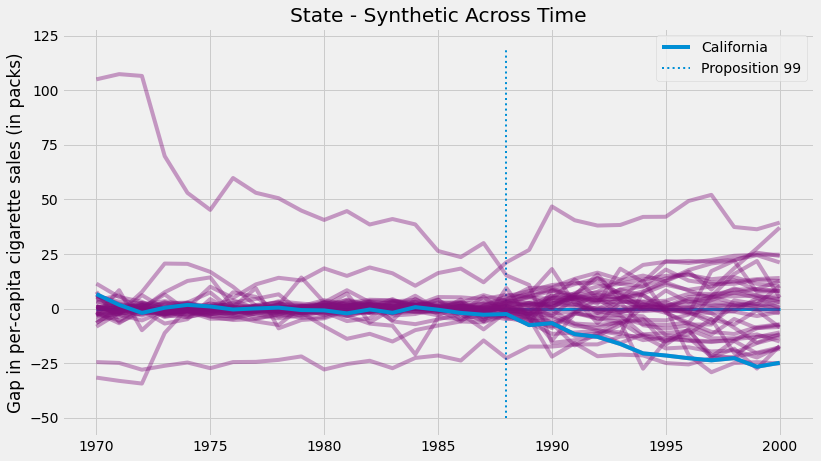

In [19]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

Two aspects of this figure jump to the eyes. First, we can see that the variance after the intervention is higher than the variance before the intervention. This is expected, since the synthetic control is designed to minimize the difference in the pre-intervention period. Another interesting aspect is that there are some units we can't fit very well even in the pre-intervention period. This is also to be expected. For example, if some states have very high cigarette consumption, no convex combination of the other states will ever match them. 

Since those units are so poorly fit, it is a good idea to remove them from the analysis. One way to do it objectively is to set a threshold for pre-intervention error 

$
MSE = \frac{1}{N}\sum\bigg(Y_t - \hat{Y}^{Synth}_t\bigg)^2
$

and remove those units with high error. If we proceed like this and plot the same figure, this is what we get.

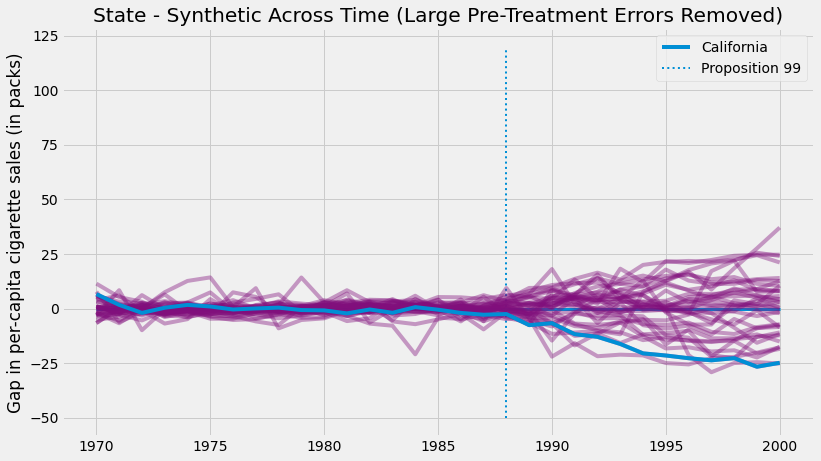

In [20]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

Removing the noise, we can see how extreme of a value is the effect in the state of California. This image shows us that if we pretend the treatment had happened to any other state, we would almost never get an effect so extreme as the one we got with California.

This picture alone is a form of inference, but we can also derive a P-value from these results. All we have to do is see how many times the effects that we've got is below the effect of California.

In [21]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.83015975607075


array([  5.79715887,   0.89458999, -24.83015976,  -7.16628121,
       -10.92204855,  37.1164056 , -15.06971721,  -0.49805125,
       -18.45795062,  21.13366447,  12.57782745,  -1.47547826,
        10.49627373, -11.67012352,   4.29850832,   8.04811402,
        14.023224  ,   8.25002775,   0.32576354,  -8.40826871,
        -2.12402707,  -7.42865061,   2.96157551,  24.10478137,
         4.25211766, -17.75844568,   7.93334017,   2.81640128,
        12.64955962, -17.47677514, -25.16040949, -12.26469139,
        24.69067386,  10.36299584,  -8.59880329])

if we want to test the one sided hypothesis that the effect in California is below zero, we can estimate the P-value as the proportion of times the effect in California is bigger than all the estimated effects.

$
PV=\frac{1}{N}\sum \mathcal{1}\{\hat{\tau}_{Calif} > \hat{\tau}_j\}
$

As it turns out, the treatment effect for California in the year 2000 is -24.8, meaning that the intervention reduced the consumption of cigarettes by almost 25 packs. Out of all the other 34 placebo effects that we've estimated, only one is higher than the effect we found in California. So the p-value would be 1/35.

In [22]:
np.mean(np.array(effects) < calif_effect)

0.02857142857142857

Finally, we can show the distribution of effects just to get a sense of how extreme the value of the effect in California really is. 

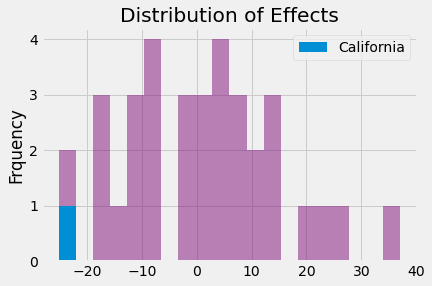

In [23]:
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();

## Key Ideas

We've learned that if we only have aggregated level data on entities like cities or states, diff-in-diff won't allow us to do inference. Also, it has some other limitations, since it has to define a control unit and one single control unit might not be a very good representation of the counterfactual for the treated unit. 

To correct for that, we learned that we can build a synthetic control that combines multiple control units to make them resemble the treated unit. With this synthetic control, we were able to see what would have happened to our treated unit in the absence of a treatment. 

Finally, we saw how we could use Fisher's Exact Tests to do inference with synthetic control. Namely, we've pretended that the non-treated units were actually the treated and computed their effect. These were the placebo effects: the effects we would observe even without a treatment. We uses these to see if the treatment effect we've estimated was statistically significant. 

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Other important reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Finally, I'd also like to compliment Scott Cunningham and his brilliant work mingling Causal Inference and Rap quotes:

* [Causal Inference: The Mixtape](https://www.scunning.com/mixtape.html)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).